# 000 preprocess
---

In [1]:
import os, gc, yaml, glob, pickle
import time
import random
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append("../src/utils")
from metric import score
from data import sep, show_df, glob_walk, set_seed, save_config_yaml, dict_to_namespace

In [3]:
# ===============
# Config
# ===============
base_path = Path("../data/processed/000_preproces_ver00")
yaml_path = base_path / "yaml" / "config.yaml"
with open(yaml_path, "r") as f:
    config = yaml.safe_load(f)
config = dict_to_namespace(config)
set_seed(config.seed)

In [7]:
# ===============
# read data
# ===============
train_dataframe = pl.read_csv(Path(config.INPUT_DIR) / "train.csv")
sep("train_dataframe"); show_df(train_dataframe)

train_dataframe
(8789, 38)


lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,mouse2_sex,mouse2_id,mouse2_age,mouse2_condition,mouse3_strain,mouse3_color,mouse3_sex,mouse3_id,mouse3_age,mouse3_condition,mouse4_strain,mouse4_color,mouse4_sex,mouse4_id,mouse4_age,mouse4_condition,frames_per_second,video_duration_sec,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
str,i64,str,str,str,f64,str,str,str,str,str,f64,str,str,str,str,str,f64,str,str,str,str,str,f64,str,str,f64,f64,f64,i64,i64,f64,f64,str,str,str,str,str
"""AdaptableSnail""",44566106,"""CD-1 (ICR)""","""white""","""male""",10.0,"""8-12 weeks""","""wireless device""","""CD-1 (ICR)""","""white""","""male""",24.0,"""8-12 weeks""","""wireless device""","""CD-1 (ICR)""","""white""","""male""",38.0,"""8-12 weeks""","""wireless device""","""CD-1 (ICR)""","""white""","""male""",51.0,"""8-12 weeks""","""wireless device""",30.0,615.6,16.0,1228,1068,60.0,60.0,"""square""","""familiar""","""[""body_center"", ""ear_left"", ""e…","""[""mouse1,mouse2,approach"", ""mo…","""DeepLabCut"""
"""AdaptableSnail""",143861384,"""CD-1 (ICR)""","""white""","""male""",3.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",17.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",31.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",44.0,"""8-12 weeks""",null,25.0,3599.0,9.7,968,608,60.0,60.0,"""square""","""familiar""","""[""body_center"", ""ear_left"", ""e…","""[""mouse1,mouse2,approach"", ""mo…","""DeepLabCut"""
"""AdaptableSnail""",209576908,"""CD-1 (ICR)""","""white""","""male""",7.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",21.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",35.0,"""8-12 weeks""",null,"""CD-1 (ICR)""","""white""","""male""",48.0,"""8-12 weeks""",null,30.0,615.2,16.0,1266,1100,60.0,60.0,"""square""","""familiar""","""[""body_center"", ""ear_left"", ""e…","""[""mouse1,mouse2,approach"", ""mo…","""DeepLabCut"""


In [20]:
# ===============
# Load Data
# ===============
train_pair_features_path = base_path / "train_pair_features.parquet"
train_frame_labels_path = base_path / "train_frame_labels.parquet"

pair_df = pl.read_parquet(train_pair_features_path)
labels_df = pl.read_parquet(train_frame_labels_path)

sep("train_pair_features_path"); show_df(pair_df,3,True); print()
sep("train_frame_labels_path"); show_df(labels_df,3,True) 

train_pair_features_path
(40929649, 98)


video_id,agent_mouse_id,target_mouse_id,video_frame,dist_body_center,dx_body_center,dy_body_center,x_agent_body_center,x_agent_ear_left,x_agent_ear_right,x_agent_hip_left,x_agent_hip_right,x_agent_lateral_left,x_agent_lateral_right,x_agent_neck,x_agent_nose,x_agent_tail_base,x_agent_tail_tip,x_target_body_center,x_target_ear_left,x_target_ear_right,x_target_hip_left,x_target_hip_right,x_target_lateral_left,x_target_lateral_right,x_target_neck,x_target_nose,x_target_tail_base,x_target_tail_tip,y_agent_body_center,y_agent_ear_left,y_agent_ear_right,y_agent_hip_left,y_agent_hip_right,y_agent_lateral_left,y_agent_lateral_right,y_agent_neck,…,x_agent_neck_is_null,x_agent_nose_is_null,x_agent_tail_base_is_null,x_agent_tail_tip_is_null,x_target_body_center_is_null,x_target_ear_left_is_null,x_target_ear_right_is_null,x_target_hip_left_is_null,x_target_hip_right_is_null,x_target_lateral_left_is_null,x_target_lateral_right_is_null,x_target_neck_is_null,x_target_nose_is_null,x_target_tail_base_is_null,x_target_tail_tip_is_null,y_agent_body_center_is_null,y_agent_ear_left_is_null,y_agent_ear_right_is_null,y_agent_hip_left_is_null,y_agent_hip_right_is_null,y_agent_lateral_left_is_null,y_agent_lateral_right_is_null,y_agent_neck_is_null,y_agent_nose_is_null,y_agent_tail_base_is_null,y_agent_tail_tip_is_null,y_target_body_center_is_null,y_target_ear_left_is_null,y_target_ear_right_is_null,y_target_hip_left_is_null,y_target_hip_right_is_null,y_target_lateral_left_is_null,y_target_lateral_right_is_null,y_target_neck_is_null,y_target_nose_is_null,y_target_tail_base_is_null,y_target_tail_tip_is_null
i32,i8,i8,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
599439,1,2,0,890.487427,-772.851074,442.344971,1916.165039,1908.050049,1931.625,0.0,0.0,1889.477051,1941.230957,0.0,1913.124023,0.0,0.0,1143.313965,1150.151978,1127.131958,0.0,0.0,1165.271973,1116.641968,0.0,1131.552002,1140.972046,1021.47699,954.812988,921.630005,918.171021,0.0,0.0,944.888,957.375,0.0,…,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0
599439,1,2,1,892.413818,-775.171997,442.165955,1918.69397,1909.560059,1931.67395,0.0,0.0,1887.517944,1941.23999,0.0,1912.579956,0.0,0.0,1143.521973,1149.863037,1127.251953,0.0,0.0,1166.974976,1116.074951,0.0,1131.755005,1139.355957,1019.768982,955.04303,922.187988,920.130981,0.0,0.0,945.458008,957.148987,0.0,…,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0
599439,1,2,2,894.417786,-775.150024,446.234924,1917.660034,1908.655029,1932.347046,0.0,0.0,1887.998047,1940.682983,0.0,1912.845947,0.0,0.0,1142.51001,1148.689941,1126.421021,0.0,0.0,1164.849976,1115.72998,0.0,1131.376953,1139.432007,1021.10498,951.153015,922.890015,920.213989,0.0,0.0,945.697998,955.575012,0.0,…,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0


video_id,agent_mouse_id,target_mouse_id,video_frame,dist_body_center,dx_body_center,dy_body_center,x_agent_body_center,x_agent_ear_left,x_agent_ear_right,x_agent_hip_left,x_agent_hip_right,x_agent_lateral_left,x_agent_lateral_right,x_agent_neck,x_agent_nose,x_agent_tail_base,x_agent_tail_tip,x_target_body_center,x_target_ear_left,x_target_ear_right,x_target_hip_left,x_target_hip_right,x_target_lateral_left,x_target_lateral_right,x_target_neck,x_target_nose,x_target_tail_base,x_target_tail_tip,y_agent_body_center,y_agent_ear_left,y_agent_ear_right,y_agent_hip_left,y_agent_hip_right,y_agent_lateral_left,y_agent_lateral_right,y_agent_neck,…,x_agent_neck_is_null,x_agent_nose_is_null,x_agent_tail_base_is_null,x_agent_tail_tip_is_null,x_target_body_center_is_null,x_target_ear_left_is_null,x_target_ear_right_is_null,x_target_hip_left_is_null,x_target_hip_right_is_null,x_target_lateral_left_is_null,x_target_lateral_right_is_null,x_target_neck_is_null,x_target_nose_is_null,x_target_tail_base_is_null,x_target_tail_tip_is_null,y_agent_body_center_is_null,y_agent_ear_left_is_null,y_agent_ear_right_is_null,y_agent_hip_left_is_null,y_agent_hip_right_is_null,y_agent_lateral_left_is_null,y_agent_lateral_right_is_null,y_agent_neck_is_null,y_agent_nose_is_null,y_agent_tail_base_is_null,y_agent_tail_tip_is_null,y_target_body_center_is_null,y_target_ear_left_is_null,y_target_ear_right_is_null,y_target_hip_left_is_null,y_target_hip_right_is_null,y_target_lateral_left_is_null,y_target_lateral_right_is_null,y_target_neck_is_null,y_target_nose_is_null,y_target_tail_base_is_null,y_target_tail_tip_is_null
i32,i8,i8,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2143302778,1,2,17254,0.0,0.0,0.0,0.0,169.019623,120.019615,219.019623,169.019623,0.0,0.0,150.019623,97.019615,223.019623,0.0,0.0,257.356049,196.356049,231.356049,173.356049,0.0,0.0,225.356049,235.356049,172.356049,0.0,0.0,171.137939,214.137939,206.137939,248.137939,0.0,0.0,197.137939,…,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1
2143302778,1,2,17255,0.0,0.0,0.0,0.0,169.372696,122.372696,219.372696,169.372696,0.0,0.0,151.372696,97.372696,223.372696,0.0,0.0,250.839325,195.839325,230.839325,172.839325,0.0,0.0,221.839325,226.839325,173.839325,0.0,0.0,174.155334,217.155334,205.155334,247.155334,0.0,0.0,198.155334,…,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1
2143302778,1,2,17256,0.0,0.0,0.0,0.0,166.568222,123.568222,218.568222,169.568222,0.0,0.0,151.568222,94.568222,223.568222,0.0,0.0,247.744919,193.744919,228.744919,176.744919,0.0,0.0,218.744919,222.744919,177.744919,0.0,0.0,173.087143,217.087143,205.087143,247.087143,0.0,0.0,199.087143,…,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1



train_frame_labels_path
(40929649, 41)


video_id,agent_mouse_id,target_mouse_id,video_frame,label_allogroom,label_approach,label_attack,label_attemptmount,label_avoid,label_biteobject,label_chase,label_chaseattack,label_climb,label_defend,label_dig,label_disengage,label_dominance,label_dominancegroom,label_dominancemount,label_ejaculate,label_escape,label_exploreobject,label_flinch,label_follow,label_freeze,label_genitalgroom,label_huddle,label_intromit,label_mount,label_rear,label_reciprocalsniff,label_rest,label_run,label_selfgroom,label_shepherd,label_sniff,label_sniffbody,label_sniffface,label_sniffgenital,label_submit,label_tussle
i32,i8,i8,i32,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
599439,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
599439,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
599439,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


video_id,agent_mouse_id,target_mouse_id,video_frame,label_allogroom,label_approach,label_attack,label_attemptmount,label_avoid,label_biteobject,label_chase,label_chaseattack,label_climb,label_defend,label_dig,label_disengage,label_dominance,label_dominancegroom,label_dominancemount,label_ejaculate,label_escape,label_exploreobject,label_flinch,label_follow,label_freeze,label_genitalgroom,label_huddle,label_intromit,label_mount,label_rear,label_reciprocalsniff,label_rest,label_run,label_selfgroom,label_shepherd,label_sniff,label_sniffbody,label_sniffface,label_sniffgenital,label_submit,label_tussle
i32,i8,i8,i32,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2143302778,1,2,17254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2143302778,1,2,17255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2143302778,1,2,17256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# カラム一覧
print("=== pair_df columns ===")
for c in pair_df.columns:
    print(c, end=", ")
    
print("\n=== labels_df columns ===")
for c in labels_df.columns:
    print(c, end=", ")

# 数値列の基本統計
display(pair_df.describe())

=== pair_df columns ===
video_id, agent_mouse_id, target_mouse_id, video_frame, dist_body_center, dx_body_center, dy_body_center, x_agent_body_center, x_agent_ear_left, x_agent_ear_right, x_agent_hip_left, x_agent_hip_right, x_agent_lateral_left, x_agent_lateral_right, x_agent_neck, x_agent_nose, x_agent_tail_base, x_agent_tail_tip, x_target_body_center, x_target_ear_left, x_target_ear_right, x_target_hip_left, x_target_hip_right, x_target_lateral_left, x_target_lateral_right, x_target_neck, x_target_nose, x_target_tail_base, x_target_tail_tip, y_agent_body_center, y_agent_ear_left, y_agent_ear_right, y_agent_hip_left, y_agent_hip_right, y_agent_lateral_left, y_agent_lateral_right, y_agent_neck, y_agent_nose, y_agent_tail_base, y_agent_tail_tip, y_target_body_center, y_target_ear_left, y_target_ear_right, y_target_hip_left, y_target_hip_right, y_target_lateral_left, y_target_lateral_right, y_target_neck, y_target_nose, y_target_tail_base, y_target_tail_tip, dist_body_center_is_null, dx

statistic,video_id,agent_mouse_id,target_mouse_id,video_frame,dist_body_center,dx_body_center,dy_body_center,x_agent_body_center,x_agent_ear_left,x_agent_ear_right,x_agent_hip_left,x_agent_hip_right,x_agent_lateral_left,x_agent_lateral_right,x_agent_neck,x_agent_nose,x_agent_tail_base,x_agent_tail_tip,x_target_body_center,x_target_ear_left,x_target_ear_right,x_target_hip_left,x_target_hip_right,x_target_lateral_left,x_target_lateral_right,x_target_neck,x_target_nose,x_target_tail_base,x_target_tail_tip,y_agent_body_center,y_agent_ear_left,y_agent_ear_right,y_agent_hip_left,y_agent_hip_right,y_agent_lateral_left,y_agent_lateral_right,…,x_agent_neck_is_null,x_agent_nose_is_null,x_agent_tail_base_is_null,x_agent_tail_tip_is_null,x_target_body_center_is_null,x_target_ear_left_is_null,x_target_ear_right_is_null,x_target_hip_left_is_null,x_target_hip_right_is_null,x_target_lateral_left_is_null,x_target_lateral_right_is_null,x_target_neck_is_null,x_target_nose_is_null,x_target_tail_base_is_null,x_target_tail_tip_is_null,y_agent_body_center_is_null,y_agent_ear_left_is_null,y_agent_ear_right_is_null,y_agent_hip_left_is_null,y_agent_hip_right_is_null,y_agent_lateral_left_is_null,y_agent_lateral_right_is_null,y_agent_neck_is_null,y_agent_nose_is_null,y_agent_tail_base_is_null,y_agent_tail_tip_is_null,y_target_body_center_is_null,y_target_ear_left_is_null,y_target_ear_right_is_null,y_target_hip_left_is_null,y_target_hip_right_is_null,y_target_lateral_left_is_null,y_target_lateral_right_is_null,y_target_neck_is_null,y_target_nose_is_null,y_target_tail_base_is_null,y_target_tail_tip_is_null
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,…,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7,4.0929649e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.0536e9,1.523577,1.805094,83422.758641,133.385056,-0.975409,0.175926,221.453781,398.576385,412.329224,176.081833,177.645309,156.346252,156.059906,176.358688,389.903748,408.406952,130.55809,220.478363,397.556702,410.785004,176.147568,176.93132,155.308762,155.163284,175.952347,388.627228,407.128571,128.774155,182.976578,289.881958,297.714935,113.921402,112.668747,131.450134,131.203293,…,0.622796,0.077957,0.020503,0.759495,0.466246,0.038265,0.020187,0.614237,0.611731,0.736681,0.736145,0.622796,0.077443,0.020958,0.759495,0.466246,0.03862,0.020495,0.613992,0.611338,0.736681,0.736145,0.622796,0.077957,0.020503,0.759495,0.466246,0.038265,0.020187,0.614237,0.611731,0.736681,0.736145,0.622796,0.077443,0.020958,0.759495
"""std""",5.8385e8,0.734864,0.668953,144641.35482,281.601807,211.644226,228.68512,315.086792,300.85498,301.509338,274.43631,275.228363,325.173889,324.466064,280.8663

### train.csvの内容確認(再度)

In [22]:
# ===================
# check lab_id
# ===================
print(len(train_dataframe["lab_id"].unique()))
print(*(train_dataframe["lab_id"].unique()))

21
CalMS21_task1 GroovyShrew LyricalHare NiftyGoldfinch CRIM13 BoisterousParrot DeliriousFly PleasantMeerkat MABe22_keypoints CalMS21_supplemental CalMS21_task2 ElegantMink UppityFerret ReflectiveManatee CautiousGiraffe SparklingTapir AdaptableSnail JovialSwallow InvincibleJellyfish TranquilPanther MABe22_movies


In [23]:
# 確認したいカラムのリスト
columns_to_check = [
    'frames_per_second', 'video_duration_sec', 'pix_per_cm_approx',
    'video_width_pix', 'video_height_pix', 'arena_width_cm',
    'arena_height_cm', 'arena_shape', 'arena_type',
    'body_parts_tracked', 'behaviors_labeled', 'tracking_method'
]
# 表示する行数を増やす
pl.Config.set_tbl_rows(100)  # 表示する行数（デフォルトは10）
# lab_idごとにグループ化して、各カラムのユニーク値を取得
result = train_dataframe.group_by('lab_id').agg([
    pl.col(col).n_unique().alias(f'{col}_unique_count')
    for col in columns_to_check
])
show_df(result,21)

(21, 13)


lab_id,frames_per_second_unique_count,video_duration_sec_unique_count,pix_per_cm_approx_unique_count,video_width_pix_unique_count,video_height_pix_unique_count,arena_width_cm_unique_count,arena_height_cm_unique_count,arena_shape_unique_count,arena_type_unique_count,body_parts_tracked_unique_count,behaviors_labeled_unique_count,tracking_method_unique_count
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""LyricalHare""",2,23,1,1,1,1,1,1,1,1,9,1
"""DeliriousFly""",2,2,1,1,1,1,1,1,1,1,1,1
"""UppityFerret""",5,3,3,4,2,1,1,1,1,1,6,1
"""CalMS21_task1""",1,100,1,1,1,1,1,1,1,1,25,1
"""SparklingTapir""",4,36,21,29,23,3,3,1,3,1,6,1
"""GroovyShrew""",1,17,7,12,12,1,1,1,1,1,17,1
"""CalMS21_task2""",1,62,1,1,1,1,1,1,1,1,1,1
"""NiftyGoldfinch""",1,10,1,1,1,1,1,1,1,1,1,1
"""JovialSwallow""",1,1,1,1,1,1,1,1,1,1,1,1


### 前処理dfの内容確認

In [ ]:
pair_df = pair_df.to_pandas()
labels_df = labels_df.to_pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


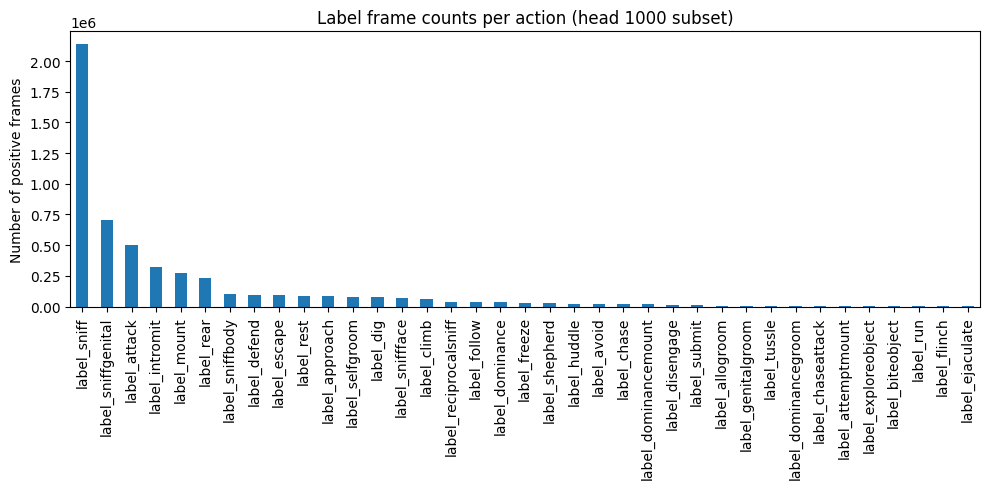

label_sniff              2135308
label_sniffgenital        702812
label_attack              504642
label_intromit            322499
label_mount               275852
label_rear                229910
label_sniffbody           103249
label_defend               89964
label_escape               89907
label_rest                 87113
label_approach             85899
label_selfgroom            81670
label_dig                  78740
label_sniffface            71527
label_climb                58564
label_reciprocalsniff      40458
label_follow               39575
label_dominance            38154
label_freeze               31660
label_shepherd             29451
label_huddle               24148
label_avoid                23242
label_chase                22208
label_dominancemount       17556
label_disengage            12021
label_submit                8430
label_allogroom             6640
label_genitalgroom          6270
label_tussle                5056
label_dominancegroom        4724
label_chas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Jupyter の表示用
%load_ext autoreload
%autoreload 2
%matplotlib inline

# label_ ではじまる列を抽出
label_cols = [c for c in labels_df.columns if c.startswith("label_")]

# 各行動の「陽性フレーム数」をカウント
label_counts = labels_df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
label_counts.plot(kind="bar")
plt.xticks(rotation=90)
plt.ylabel("Number of positive frames")
plt.title("Label frame counts per action (head 1000 subset)")
plt.tight_layout()
plt.show()

label_counts

video_id=599439, agent=1, target=2


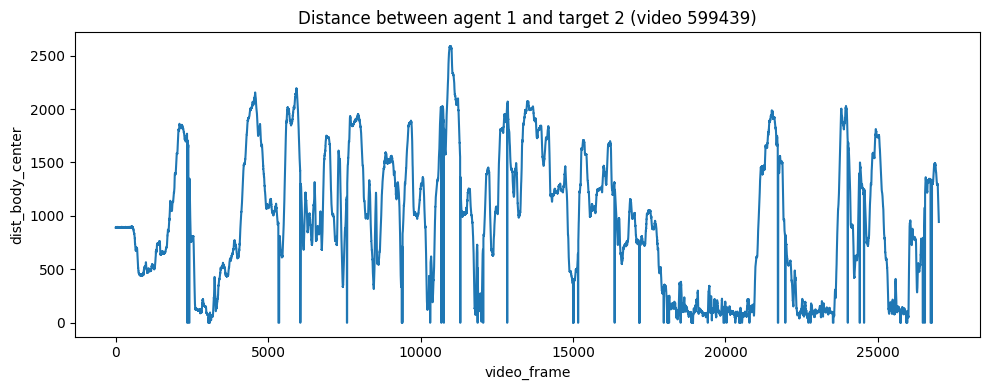

,video_id,agent_mouse_id,target_mouse_id,video_frame,dist_body_center,dx_body_center,dy_body_center,x_agent_body_center,x_agent_ear_left,x_agent_ear_right,...,y_target_ear_left_is_null,y_target_ear_right_is_null,y_target_hip_left_is_null,y_target_hip_right_is_null,y_target_lateral_left_is_null,y_target_lateral_right_is_null,y_target_neck_is_null,y_target_nose_is_null,y_target_tail_base_is_null,y_target_tail_tip_is_null
0,599439,1,2,0,890.487427,-772.851074,442.344971,1916.165039,1908.050049,1931.625000,...,0,0,1,1,0,0,1,0,0,0
1,599439,1,2,1,892.413818,-775.171997,442.165955,1918.693970,1909.560059,1931.673950,...,0,0,1,1,0,0,1,0,0,0
2,599439,1,2,2,894.417786,-775.150024,446.234924,1917.660034,1908.655029,1932.347046,...,0,0,1,1,0,0,1,0,0,0
3,599439,1,2,3,894.806213,-777.385986,443.113037,1919.629028,1909.057007,1933.331055,...,0,0,1,1,0,0,1,0,0,0
4,599439,1,2,4,897.020142,-779.130005,444.523987,1920.728027,1908.917969,1933.391968,...,0,0,1,1,0,0,1,0,0,0


In [ ]:
# ==================
# video/ペアごとの距離の推移をプロットして確認
# ==================
# 1つ適当な video_id & ペアを取る
sample = pair_df[["video_id", "agent_mouse_id", "target_mouse_id"]].head(1).iloc[0]
vid  = sample["video_id"]
a_id = sample["agent_mouse_id"]
t_id = sample["target_mouse_id"]

print(f"video_id={vid}, agent={a_id}, target={t_id}")

pair_sub = pair_df[
    (pair_df["video_id"] == vid) &
    (pair_df["agent_mouse_id"] == a_id) &
    (pair_df["target_mouse_id"] == t_id)
].sort_values("video_frame")

plt.figure(figsize=(10, 4))
plt.plot(pair_sub["video_frame"], pair_sub["dist_body_center"])
plt.xlabel("video_frame")
plt.ylabel("dist_body_center")
plt.title(f"Distance between agent {a_id} and target {t_id} (video {vid})")
plt.tight_layout()
plt.show()

pair_sub.head()

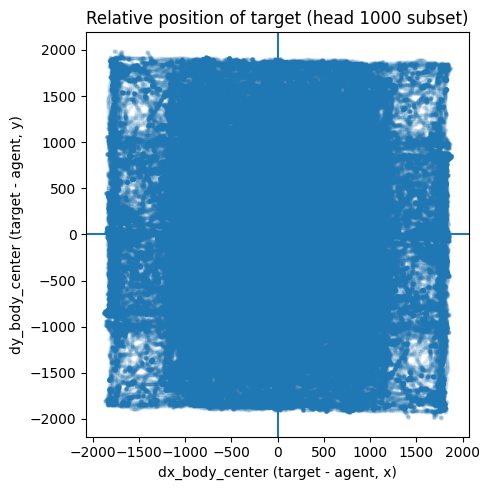

In [34]:
# ============================
# agentからのdx,dyを散布図で確認
# ============================
plt.figure(figsize=(5, 5))
plt.scatter(pair_df["dx_body_center"], pair_df["dy_body_center"], s=5, alpha=0.05)
plt.axhline(0)
plt.axvline(0)
plt.xlabel("dx_body_center (target - agent, x)")
plt.ylabel("dy_body_center (target - agent, y)")
plt.title("Relative position of target (head 1000 subset)")
plt.tight_layout()
plt.show()

In [35]:
#　特徴とラベルをjoinして確認
INDEX_COLS = ["video_id", "agent_mouse_id", "target_mouse_id", "video_frame"]

merged = pair_df.merge(labels_df, on=INDEX_COLS, how="inner")
sep("merged")
show_df(merged)

merged shape: (40929649, 135)


,video_id,agent_mouse_id,target_mouse_id,video_frame,dist_body_center,dx_body_center,dy_body_center,x_agent_body_center,x_agent_ear_left,x_agent_ear_right,...,label_rest,label_run,label_selfgroom,label_shepherd,label_sniff,label_sniffbody,label_sniffface,label_sniffgenital,label_submit,label_tussle
0,599439,1,2,0,890.487427,-772.851074,442.344971,1916.165039,1908.050049,1931.625000,...,0,0,0,0,0,0,0,0,0,0
1,599439,1,2,1,892.413818,-775.171997,442.165955,1918.693970,1909.560059,1931.673950,...,0,0,0,0,0,0,0,0,0,0
2,599439,1,2,2,894.417786,-775.150024,446.234924,1917.660034,1908.655029,1932.347046,...,0,0,0,0,0,0,0,0,0,0
3,599439,1,2,3,894.806213,-777.385986,443.113037,1919.629028,1909.057007,1933.331055,...,0,0,0,0,0,0,0,0,0,0
4,599439,1,2,4,897.020142,-779.130005,444.523987,1920.728027,1908.917969,1933.391968,...,0,0,0,0,0,0,0,0,0,0


attack: pos_frames=504642, neg_frames=40425007


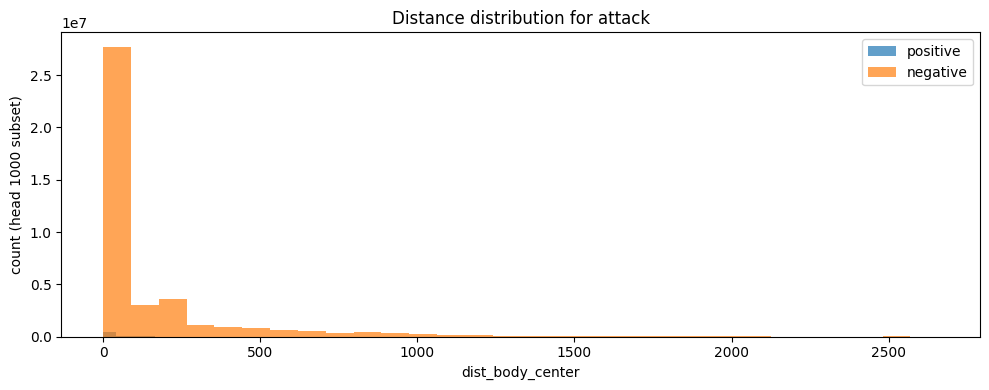

In [36]:
# ==========================================
# attack が立っているフレームの距離を見てみる
# ==========================================
action = "attack"
label_col = f"label_{action}"

merged = pair_df.merge(labels_df, on=INDEX_COLS, how="inner")

pos = merged[merged[label_col] == 1]
neg = merged[merged[label_col] == 0]

print(f"{action}: pos_frames={len(pos)}, neg_frames={len(neg)}")

plt.figure(figsize=(10, 4))
plt.hist(pos["dist_body_center"], bins=30, alpha=0.7, label="positive")
plt.hist(neg["dist_body_center"], bins=30, alpha=0.7, label="negative")
plt.xlabel("dist_body_center")
plt.ylabel("count (head 1000 subset)")
plt.title(f"Distance distribution for {action}")
plt.legend()
plt.tight_layout()
plt.show()